In [6]:
# Import all necessary modules
import time
import math
import numpy as  np
import matplotlib.pyplot as plt
import sounddevice as sd
from copy import copy
np.set_printoptions(precision=2)

In [2]:
# Set up the SDR
# Need to do this before you can adjust sampling frequency
# Drivers must be installed for this to work
# If this gives an error (eg because another program is controlling
# the SDR), close the other program and restart this kernel
from rtlsdr import RtlSdr 
# Close previous instances of the sdr object
try: 
    sdr.close()
except NameError:
   pass

sdr = RtlSdr() # Create a new sdr object (by keeping this in 
               # the block above can be used to close sdr without
               # creating a new sdr instance, which you might want to
               # do when switching to a new program
               # If this fails, try 
               # (1) running close block above
               # (2) closing other programs that may be using SDR
               # (3) restart this kernel

In [9]:
# Set up constants.

# Radio sampling frequency. 2^21 ~= about 2Msps. 
# Supposedly the chips on these aren't good for pushing more than 2.2 MHz
fsps = 2 ** 21

# How long to sample for in seconds
samplesecs = 2

# Total number of samples to take
N = fsps * samplesecs

# audio sampling frequency (for output)
faudiosps = 48000

# Center frequency
fc = 94.9e6 # KUOW Seattle
#fc = 89.7e6 # KWWS Walla Walla
#fc = 90.3e6 # Some Seattle station
#fc = 89.8e6 # adjacent to 89.7 for validation

#fc = 92.6e6 # adjacent to spanish language station at 92.5

# For SMArt XTR...small gap at 1100MHz
#fcmin = 55e6
#fcmax = 2300e6

#fcmin = 88e6 # lowest freq in US FM band
#fcmax = 108e6 # highest freq in US FM band

# time step size between samples
dt = 1.0/fsps

# Nyquist frequency is one half of sampling frequency
nyquist = fsps / 2.0

In [30]:
# Set sdr properties
sdr.sample_rate = fsps 
sdr.center_freq = fc

# For KUOW gains too high will cause clipping of readings
sdr.gain = 10

print(f"Sampling at: {sdr.sample_rate} Hz")
print(f"Center frequency: {sdr.center_freq} Hz")
print("Gain (dB): ", sdr.gain)

print(f"Collecting {N} samples...")

samples = sdr.read_samples(N)

N_actual = len(samples)

print(f"Actual number of collected samples: {N_actual}")

Sampling at: 2097152.0 Hz
Center frequency: 94900000 Hz
Gain (dB):  8.7
Actual number of collected samples: 4194304


Text(0, 0.5, 'Time [s]')

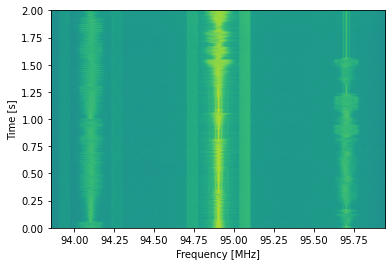

In [31]:
# This cell creates a spectrogram of the received data over time

# How many samples to use for each fft. Prefer powers of 2 for speed in fft
fft_width = 2048
num_rows = math.floor(N_actual / fft_width)

spectrogram = np.zeros((num_rows, fft_width))

for i in range(num_rows):
    spectrogram[i,:] = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(samples[fft_width * i : fft_width * (i + 1)]))) ** 2)

plt.imshow(spectrogram, aspect='auto', extent=[(fc - nyquist) / 1e6, (fc + nyquist) / 1e6, 0, len(samples) / sdr.sample_rate])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")

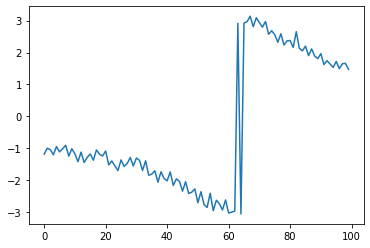

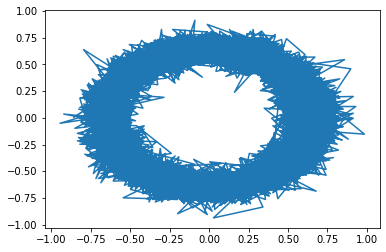

In [32]:
# Demodulate the FM signal

# First convert the samples into an array of phases (angles theta)
theta = np.arctan2(samples.imag, samples.real)

# Graph what the phase data looks like
plt.figure()
plt.plot(theta[0:100])

# Graphing imaginary and real components over time
plt.figure()
plt.plot(samples.real[0:10024], samples.imag[0:10024])